In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from keras.preprocessing.image import load_img, img_to_array,ImageDataGenerator
from evaluate import evaluate
from utils import img_parts_generator, top3acc, top5acc, labels_contiguous, get_img_array
from inceptionv4 import create_model, two_towers_top
from scipy.misc import imsave
import time
import os
from keras import backend as K
import pickle

In [5]:
def plot_data(img, orig_x1, orig_y1, orig_x2, orig_y2, pred_x1, pred_y1, pred_x2, pred_y2):
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(img)
    orig_width = orig_x2 - orig_x1
    orig_height = orig_y2 - orig_y1
    # Create a Rectangle patch
    rect = patches.Rectangle((orig_x1, orig_y1),orig_width, orig_height,linewidth=2,edgecolor='g',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    pred_width = pred_x2 - pred_x1
    pred_height = pred_y2 - pred_y1
    rect = patches.Rectangle((pred_x1, pred_y1),pred_width,pred_height,linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()
    
def plot_img(img, x=None, y=None, save=None):
    implot = plt.imshow(img)
    if x is not None and y is not None:
        plt.plot(x,y,'o', marker=5)
    if save:
        imsave(img,path)
    plt.show()

200
500


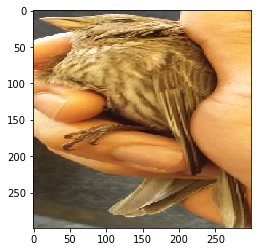

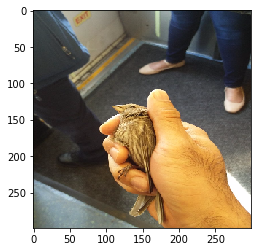

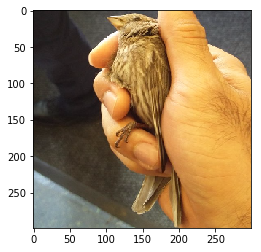

In [38]:
from utils import get_idx2label
idx2label = get_idx2label('../../CUB_200_2011/pyscripts/unique_labels200.txt')
print(len(idx2label))
idx2label500 = get_idx2label('unique_labels500.txt')
print(len(idx2label500))
caught_cropped = get_img_array('caught_cropped.png')
plot_img(caught_cropped)
caught = get_img_array('caught.png')
plot_img(caught)
caught_semi_crop = get_img_array('caught_semi_crop.png')
plot_img(caught_semi_crop)

In [11]:
idx2label[0]

'Acadian_Flycatcher'

In [39]:
# load model
#weights = '../../CUB_200_2011/pyscripts/best_weights/cub_crop_defrost_all_85.hdf5'
weights = 'best_weights/defrost_all_cropped_77.hdf5'
model = create_model(num_classes=500,
                     include_top=True, 
                     weights=weights)
print(model.summary())

Inceptionv4 Base loaded


/home/ubuntu/birdsnap_dataset/deepbirdsnap/inceptionv4.py:400: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  top_model = Model(input=inputs, output=x)
/home/ubuntu/birdsnap_dataset/deepbirdsnap/inceptionv4.py:465: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("mo...)`
  fused = Model(input=base_inputs, output=top(base(base_inputs)))


Weights loaded
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v4 (Model)         (None, 8, 8, 1536)        41174400  
_________________________________________________________________
model_9 (Model)              (None, 500)               768500    
Total params: 41,942,900.0
Trainable params: 41,879,732.0
Non-trainable params: 63,168.0
_________________________________________________________________
None


In [40]:
# test single image
probs = model.predict(np.reshape(caught_semi_crop,(1,299,299,3)))
probs = probs[0]
top10 = probs.argsort()[-10:][::-1]#np.argpartition(probs[0], -10)[-10:]
print(top10)
print(probs[top10])
top10 = [idx2label500[t] for t in top10]
print(top10)

[423 258 229 241 165 116 248 324 371 114]
[ 0.44927868  0.14880656  0.14846019  0.10437921  0.02053767  0.01432465
  0.01313596  0.01294785  0.01175202  0.0089458 ]
['Swainsons_Thrush', 'Least_Sandpiper', 'Henslows_Sparrow', 'House_Wren', 'Eastern_Meadowlark', 'Cassins_Sparrow', 'Ladder_backed_Woodpecker', 'Palm_Warbler', 'Rock_Wren', 'Cassins_Finch']


In [34]:
# test single image
probs = model.predict(np.reshape(caught_cropped,(1,299,299,3)))
probs = probs[0]
top10 = probs.argsort()[-10:][::-1]#np.argpartition(probs[0], -10)[-10:]
print(top10)
print(probs[top10])
top10 = [idx2label[t] for t in top10]
print(top10)

[177 173  36 122 116 125 127  70 170 118]
[ 0.57417083  0.1315051   0.04290734  0.04014793  0.01954087  0.01414879
  0.01341831  0.0114123   0.0111333   0.01104864]
['178.Swainson_Warbler', '174.Palm_Warbler', '037.Acadian_Flycatcher', '123.Henslow_Sparrow', '117.Clay_colored_Sparrow', '126.Nelson_Sharp_tailed_Sparrow', '128.Seaside_Sparrow', '071.Long_tailed_Jaeger', '171.Myrtle_Warbler', '119.Field_Sparrow']


In [ ]:
# load data
gen_factory = ImageDataGenerator(rescale=1./255)

validation_generator = gen_factory.flow_from_directory(
    '../validation',
    target_size=(299, 299),
    batch_size=100,
    shuffle=False)

test_generator = gen_factory.flow_from_directory(
    '../test',
    target_size=(299, 299),
    batch_size=100,
    shuffle=False)



In [ ]:
valid_labels = labels_contiguous(6,num_classes=500)
test_labels = labels_contiguous(9,num_classes=500)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy', top3acc, top5acc])

In [ ]:
# evaluate model on val and test sets
res_val = model.evaluate_generator(validation_generator, 3000//100)
print(res_val)
res_test = model.evaluate_generator(test_generator, 4500//100)
print(res_test)

In [ ]:
preds = model.predict_generator(validation_generator, 3000//100, verbose=1)

In [ ]:
len(valid_labels[0])

In [ ]:
def get_label_name(index):
    f = open('train_labels.txt', 'r').readlines()
    s = set()
    for c in f:
        s.add(c)
    mapping = list(s)
    mapping.sort()
    return mapping[index]

In [ ]:
#load data from custom generator
gen = img_parts_generator('parts_info.txt', 
                          data_dir='../validation/', 
                          batch_size=100, load_image=True, load_paths=False, load_parts=False, cache=False)

In [ ]:
preds_gen = None
count = 0
for imgs in gen:
    #print(type(imgs[0]))
    prediction = model.predict(imgs[0], 100)
    #print(np.argmax(prediction).shape)
    if preds_gen is None:
        preds_gen = prediction
    else:
        preds_gen = np.vstack((preds_gen, prediction))
    #print(type(preds_gen))
    count += 100
    print(count)
    


In [ ]:
mistakes = 0
index = []
for i, (pred,tgt) in enumerate(zip(preds_gen, valid_labels)):
    #print(i)
    if np.argmax(pred) != np.argmax(tgt):
        mistakes += 1
        index.append(i)
print(mistakes)
print(len(index))


In [ ]:
print(get_label_name(np.argmax(valid_labels[1780])))

In [ ]:
print(get_label_name(np.argmax(preds_gen[1780])))

In [ ]:
#load data from custom generator
index_set = set(index)
gen = img_parts_generator('parts_info.txt', 
                          data_dir='../validation/', 
                          batch_size=1, load_image=True, load_paths=True, load_parts=False, cache=False)

In [ ]:
import re

In [ ]:
count = 0
wrong_classified_path = []
for imgs, paths in gen:
    img = imgs[0]
    path = paths[0]
    if count in index_set:
        if '333760' in path:
            print("Found: ", count)
        wrong_classified_path.append(path)
    count += 1
    if count%50 == 0:
        print(count)
len(wrong_classified_path)

In [ ]:
wrong_classified_path[0]

In [ ]:
with open('wrong_classified_60','wb') as f:
    pickle.dump(wrong_classified_path,f)

In [ ]:
wrong_classified_path = pickle.load(open('wrong_classified_60', 'rb'))

In [ ]:
from shutil import copyfile, copy2
from image_cropper import get_save_path
save_path = '../wrong_classified_60'

In [ ]:
for path in wrong_classified_path:
    new_path = get_save_path(path, save_path)
    copyfile(path, new_path)

    

In [ ]:
validation_data = np.load(open('/data/bottlenecks_bak/cropped_pred_77_validation.npy', 'rb'))
validation_data2 = np.load(open('/data/bottlenecks_bak/bottleneck_60_validation.npy', 'rb'))

In [ ]:
validation_labels = labels_contiguous(6,num_classes=500)
validation_labels2 = labels_contiguous(6,num_classes=500)

In [ ]:
top_model, x, top_model_inputs = two_towers_top(weights='best_weights/two_towers_top_predAndWhole82.hdf5')

In [ ]:
validation_data.shape

In [ ]:
top_model.compile(optimizer='adam',
  loss='categorical_crossentropy')

In [ ]:
gen = img_parts_generator('parts_info.txt', 
                          data_dir='../validation/', 
                          batch_size=10, load_image=True, load_paths=False, load_parts=False, cache=False)

In [ ]:
preds_gen = None
count = 0
for imgs in gen:
    
    v1 = validation_data[count:count+10, :, :, :]
    v2 = validation_data2[count:count+10, :, :, :]
    v = [v1, v2]
    prediction = top_model.predict(v, 10)
    
    if preds_gen is None:
        preds_gen = prediction
    else:
        preds_gen = np.vstack((preds_gen, prediction))
    #print(type(preds_gen))
    count += 10
    print(count)
    


In [ ]:
mistakes = 0
index = []
for i, (pred,tgt) in enumerate(zip(preds_gen, validation_labels)):
    #print(i)
    if np.argmax(pred) != np.argmax(tgt):
        mistakes += 1
        index.append(i)
print(mistakes)
print(len(index))


In [ ]:
print(get_label_name(np.argmax(preds_gen[1877])))
print(get_label_name(np.argmax(validation_labels[1877])))

In [ ]:
import re

In [ ]:
index_set_twin = set(index)
gen = img_parts_generator('parts_info.txt', 
                          data_dir='../validation/', 
                          batch_size=1, load_image=True, load_paths=True, load_parts=False, cache=False)

count = 0
wrong_classified_path = []
for imgs, paths in gen:
    img = imgs[0]
    path = paths[0]
    if count in index_set_twin:
        if "576390" in path:
            print("Found: ", count)
        wrong_classified_path.append(path)
    count += 1
    if count%50 == 0:
        print(count)
len(wrong_classified_path)

In [ ]:
from shutil import copyfile, copy2
from image_cropper import get_save_path
save_path = '../top_two_towers_82'

In [ ]:
for path in wrong_classified_path:
    new_path = get_save_path(path, save_path)
    copyfile(path, new_path)

    